**CS19_cortex-alt-Triku**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import triku as tk

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.9.2 umap==0.5.3 numpy==1.21.1 scipy==1.8.0 pandas==1.2.4 scikit-learn==1.1.1 statsmodels==0.13.2 igraph==0.9.10 pynndescent==0.5.7


In [3]:
results_file = '/group/testa/Project/CBOProgPools/h5ad/CS19_01_20240208_v1.h5ad'  # the file that will store the analysis results

In [4]:
geschwind_ext = {
  'astrocytes' : ['S100B','AQP4'],
  'pericyte' : ['RGS5'],
  'microglia' : ['AIF1'],
  'endothelial' : ['ITM2A','CLDN5','ESAM'],
  'ExcDeepLayer' : ['SOX5'],
  'Interneurons' : ['DLX1','DLX2','DLX5'],
  'MatUpperEnr' : ['STMN2','SATB2','LMO4'],
  'IP' : ['PPP1R17','SSTR2','EOMES','PENK'],
  'MatExc' : ['SATB2','STMN2'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'OPCs' : ['PTPRZ1','OLIG1','PDGFRA'],
  'RG' : ['VIM','PTPRZ1','SOX2','SLC1A3','HES1','HOPX'],
  'Exc_CAMK2A+' : ['CAMK2A'],
  'Exc_TBR1+' : ['TBR1']
}

In [5]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations
# of the data. It also comes with its own HDF5-based file format: .h5ad.
adata = sc.read_10x_mtx(
    '/group/testa/Project/CBOProgPools/data/CS19_cortex/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/group-testa-Project-CBOProgPools-data-CS19_cortex-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 1349 × 33694
    var: 'gene_ids'

# Data Preparation

normalizing counts per cell
    finished (0:00:00)


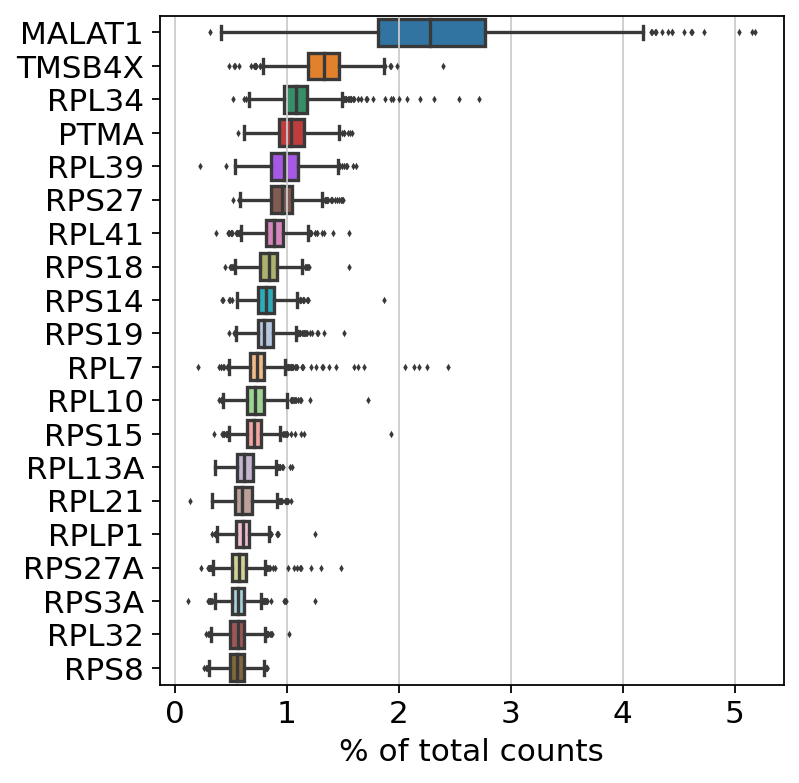

In [8]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)

filtered out 22145 genes that are detected in less than 50 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var['ribo'] = adata.var_names.str.startswith('RPL')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

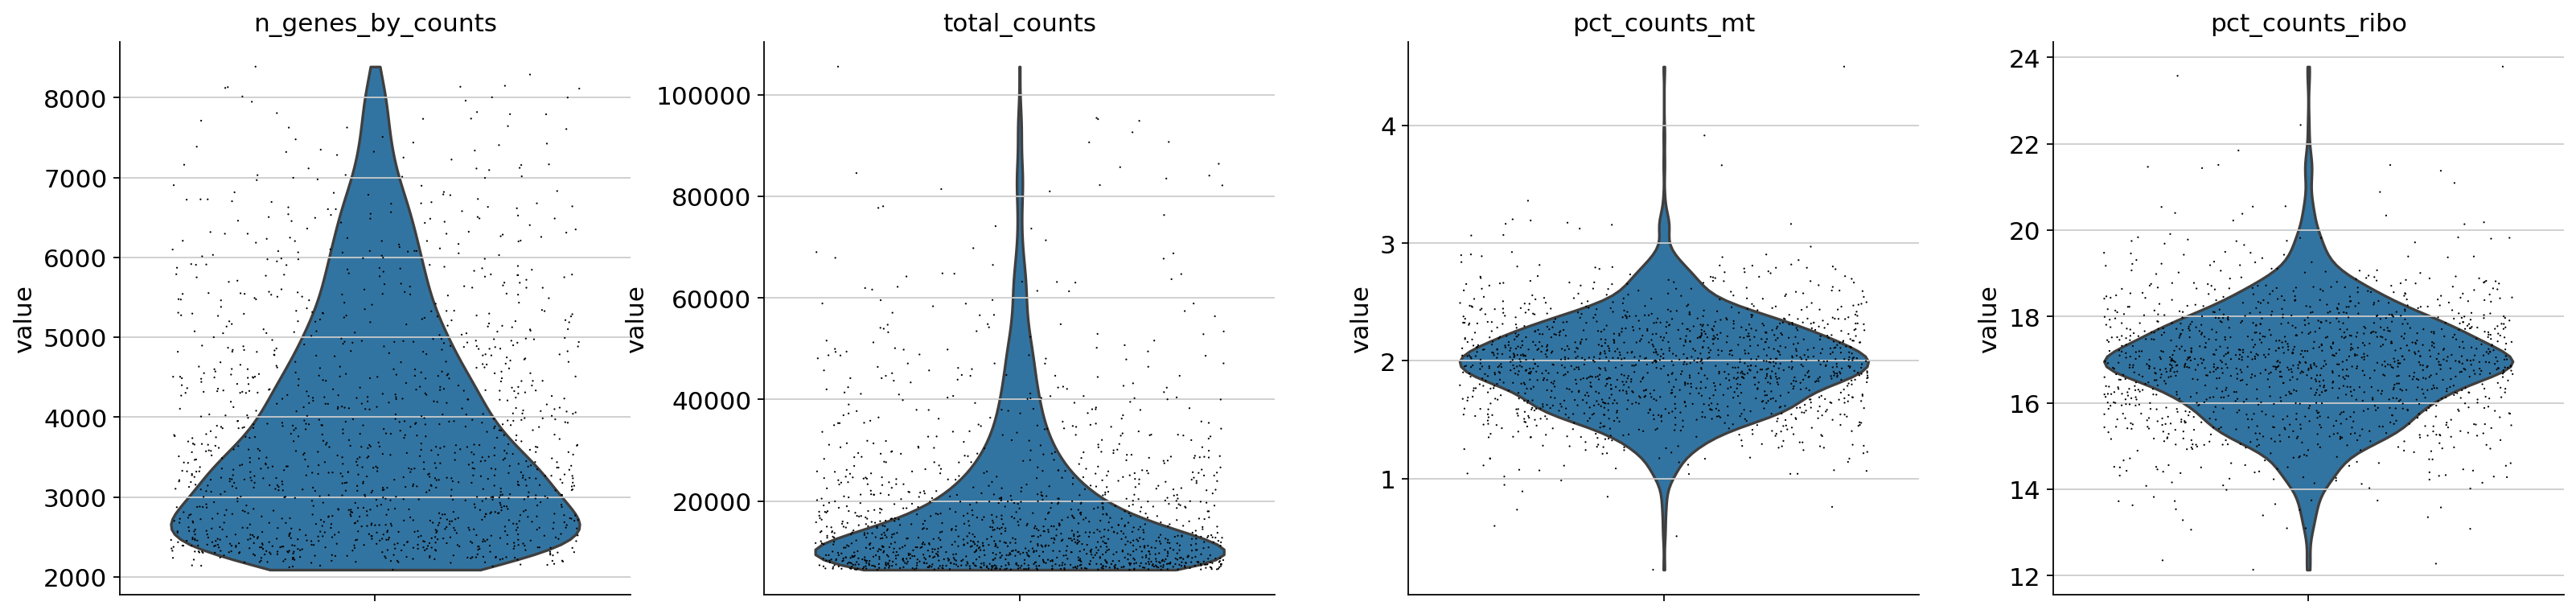

In [11]:
# A violin plot of some of the computed quality measures:
   # the number of genes expressed in the count matrix
   # the total counts per cell
   # the percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

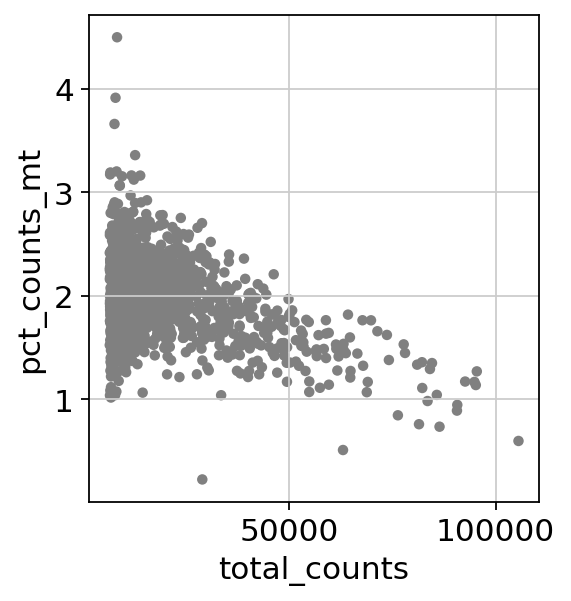

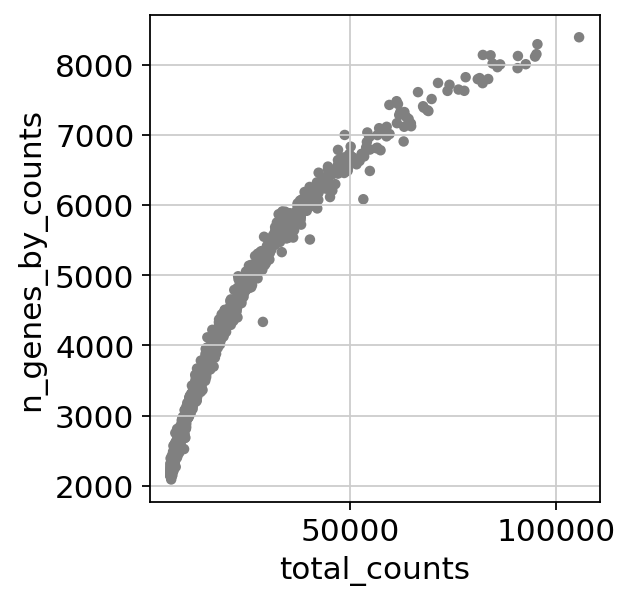

In [12]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.total_counts <= 80000]

In [14]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [15]:
s_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/S_genes",index_col=0,header=None)
g2m_genes = pd.read_csv("/group/testa/Project/CBOProgPools/ReferenceFiles/G2M_genes",index_col=0,header=None)
sc.tl.score_genes_cell_cycle(adata,s_genes.index,g2m_genes.index)

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, copying.


    finished: added
    'S_score', score of gene set (adata.obs).
    640 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    643 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [16]:
adata.obs.keys()

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score',
       'G2M_score', 'phase'],
      dtype='object')

In [17]:
adata.obs.phase.value_counts()

G2M    1081
G1      236
S        16
Name: phase, dtype: int64

In [18]:
sc.external.pp.scrublet(adata)

Running Scrublet
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 2.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.8%
    Scrublet finished (0:00:02)


In [19]:
adata.obs.predicted_doublet.value_counts()

False    1330
True        3
Name: predicted_doublet, dtype: int64

In [20]:
adata.raw = adata.copy()
adata.layers['Raw'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=80000) # highest meaningful coverage (see tot_counts)
adata.layers['normalized'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['logNorm'] = adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


In [21]:
adata

AnnData object with n_obs × n_vars = 1333 × 11549
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'
    uns: 'scrublet', 'log1p'
    layers: 'Raw', 'normalized', 'logNorm'

In [22]:
sc.pp.pca(adata, use_highly_variable=False)

sc.pp.neighbors(adata, metric='cosine', n_neighbors=int(0.5 * len(adata) ** 0.5)) #25 , 50. 75, 100
 
## Triku

tk.tl.triku(adata, use_raw=False)

Top20Triku = adata.var.sort_values(by=['triku_distance'], ascending=False).head(20).index
Top20Triku

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


Index(['RSPO1', 'OTX2', 'MALAT1', 'RSPO2', 'PALMD', 'MSX2', 'ZNF503', 'MAF',
       'LHX5-AS1', 'TPBG', 'RPL18A', 'CDH11', 'ATP1A2', 'CALB1', 'DKK4',
       'RPS19', 'NR2F2', 'WNT2B', 'C5orf49', 'MGST1'],
      dtype='object')

In [23]:
adata.var_names[adata.var['highly_variable'] == True]

Index(['AGRN', 'NADK', 'GNB1', 'NPHP4', 'KLHL21', 'PHF13', 'PDPN', 'KAZN',
       'IGSF21', 'ID3',
       ...
       'PNPLA3', 'WNT7B', 'GRAMD4', 'MIR99AHG', 'IFNAR2', 'AGPAT3', 'COL18A1',
       'LSS', 'PCNT', 'S100B'],
      dtype='object', length=433)

# Principle Component Analysis

In [24]:
# Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main 
# axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'phase' as categorical


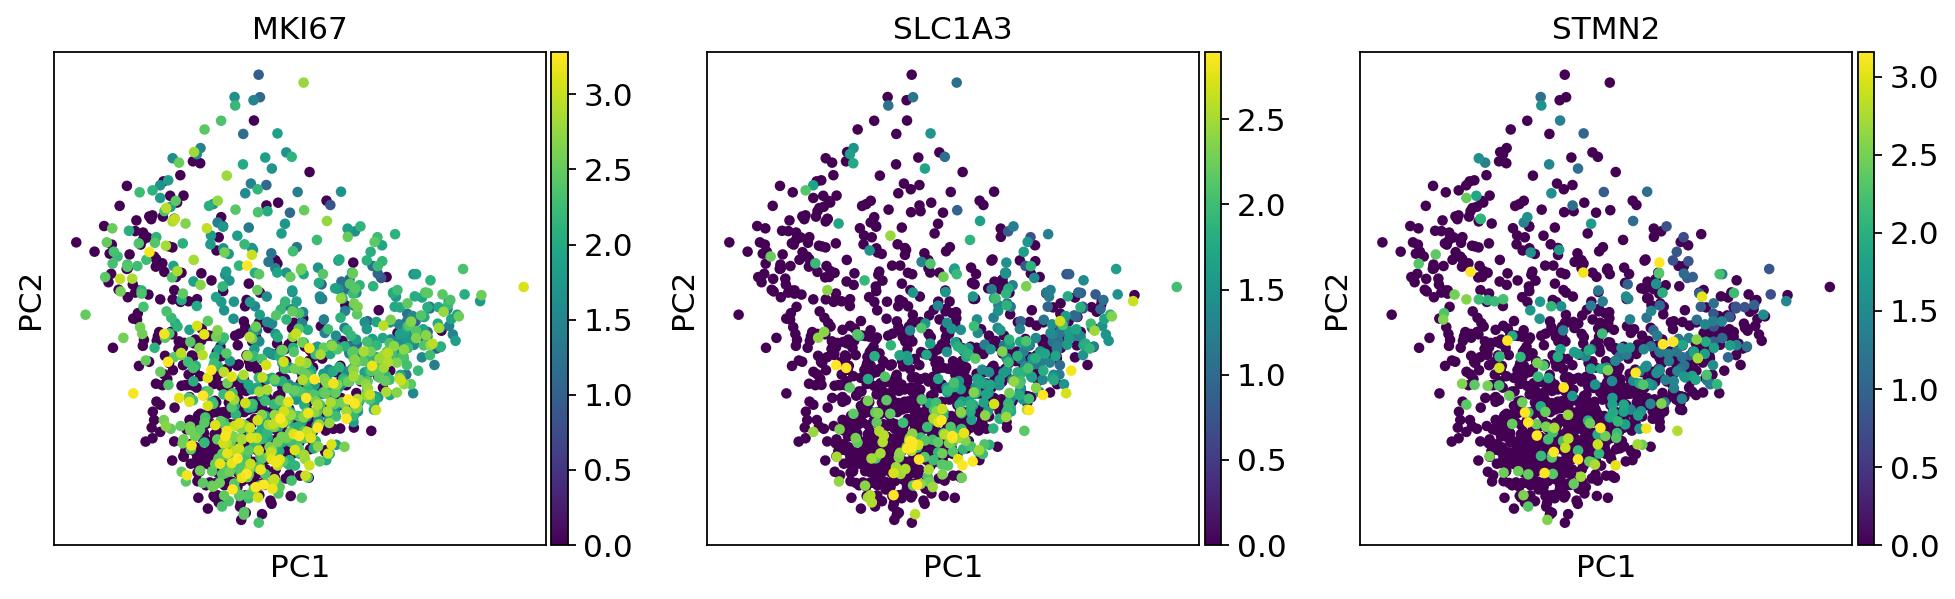

In [25]:
# We can make a scatter plot in the PCA coordinates, but we will not use that later on.

# MKI67 = cycling cell (usually progenitors, aRG / bRG / IP)
# EOMES = IP specific
# SLC1A3 = Radial Glia in general, including glia
# HOPX = bRG specific
# DCX = immature neurons
# STMN2 neurons in general

sc.pl.pca(adata, color=['MKI67','SLC1A3','STMN2'],use_raw=False,vmin="p1",vmax="p99") # ??????????????????????

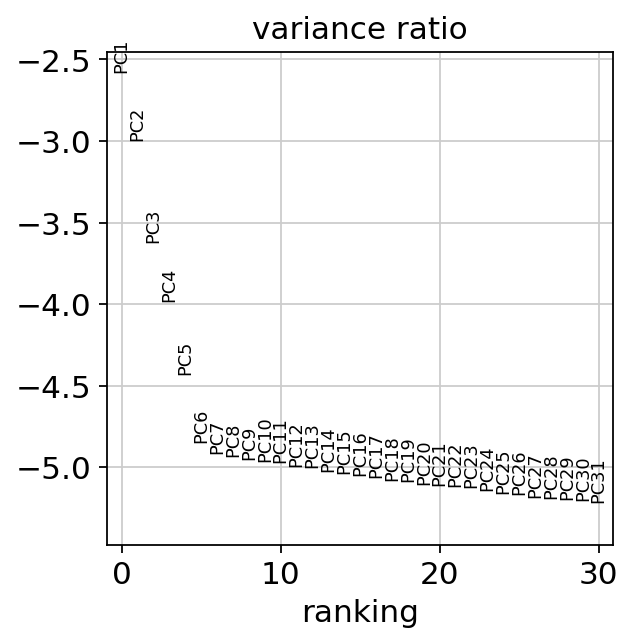

In [26]:
# Let us inspect the contribution of single PCs to the total variance in the data. 
# This gives us information about how many PCs we should consider in order to compute 
# the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() 
# or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.
sc.pl.pca_variance_ratio(adata, log=True)

In [27]:
# saving the result
adata.write(results_file)

In [28]:
adata

AnnData object with n_obs × n_vars = 1333 × 11549
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    uns: 'scrublet', 'log1p', 'pca', 'neighbors', 'triku_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'Raw', 'normalized', 'logNorm'
    obsp: 'distances', 'connectivities'

# Computing Neighborhood Graph 

In [29]:
int(0.5 * len(adata) ** 0.5)

18

In [30]:
# Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. 
# You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=6)

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


# Embedding Neighborhood Graph

In [31]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")
# small resolution ==> less clusters 
# 0.4 - 1.5

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [32]:
adata.obs.leiden.value_counts()

0    265
1    252
2    202
3    195
4    152
5    138
6    129
Name: leiden, dtype: int64

In [33]:
# We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. 
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it 
# better preserves trajectories. In some ocassions, you might still observe disconnected clusters and
# similar connectivity violations. They can usually be remedied by running:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


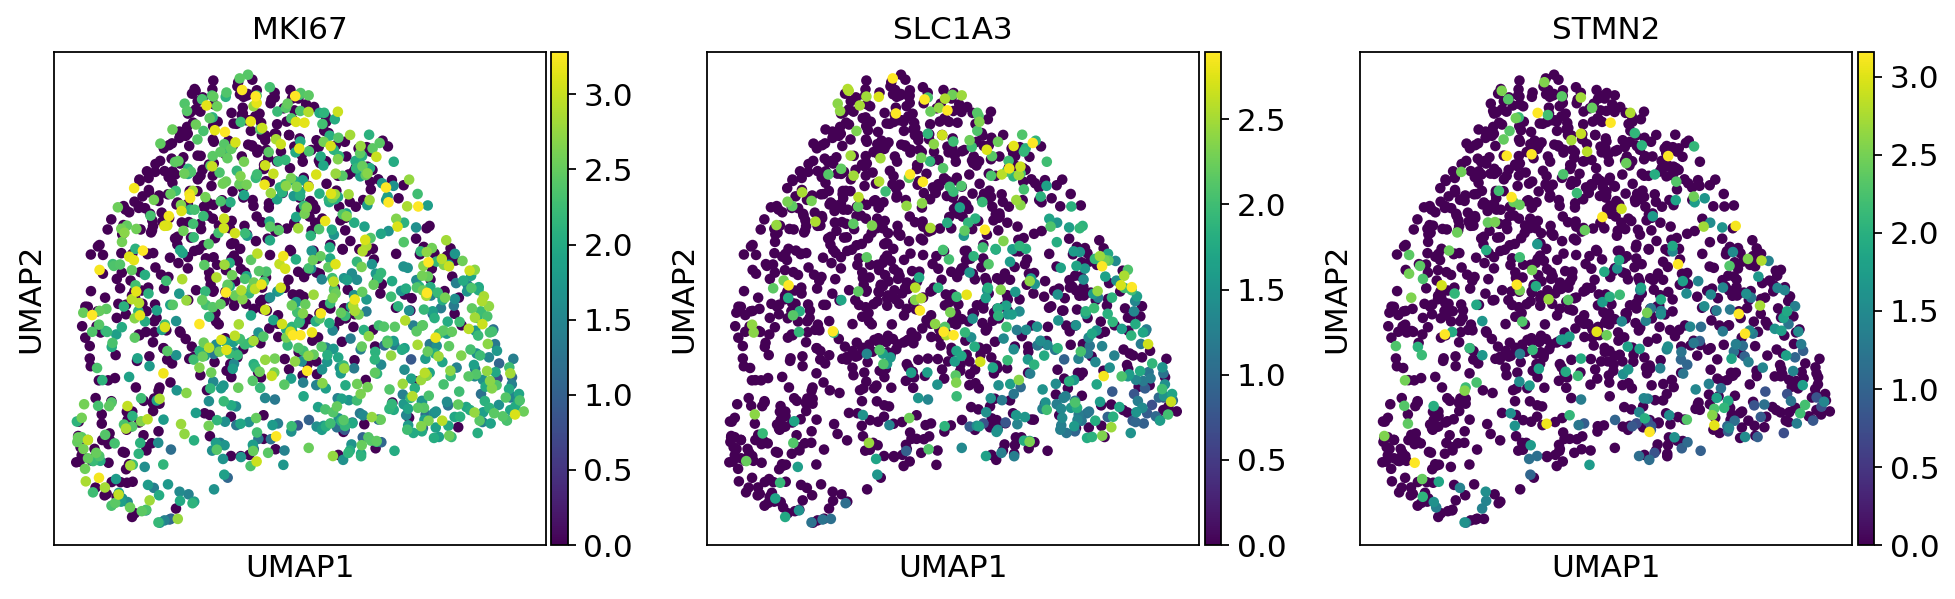

In [35]:
# As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) 
# gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to 
# use .raw.
sc.pl.umap(adata, color=['MKI67','SLC1A3','STMN2'], use_raw=False,vmin="p1",vmax="p99")

# Clustering Neighborhood Graph

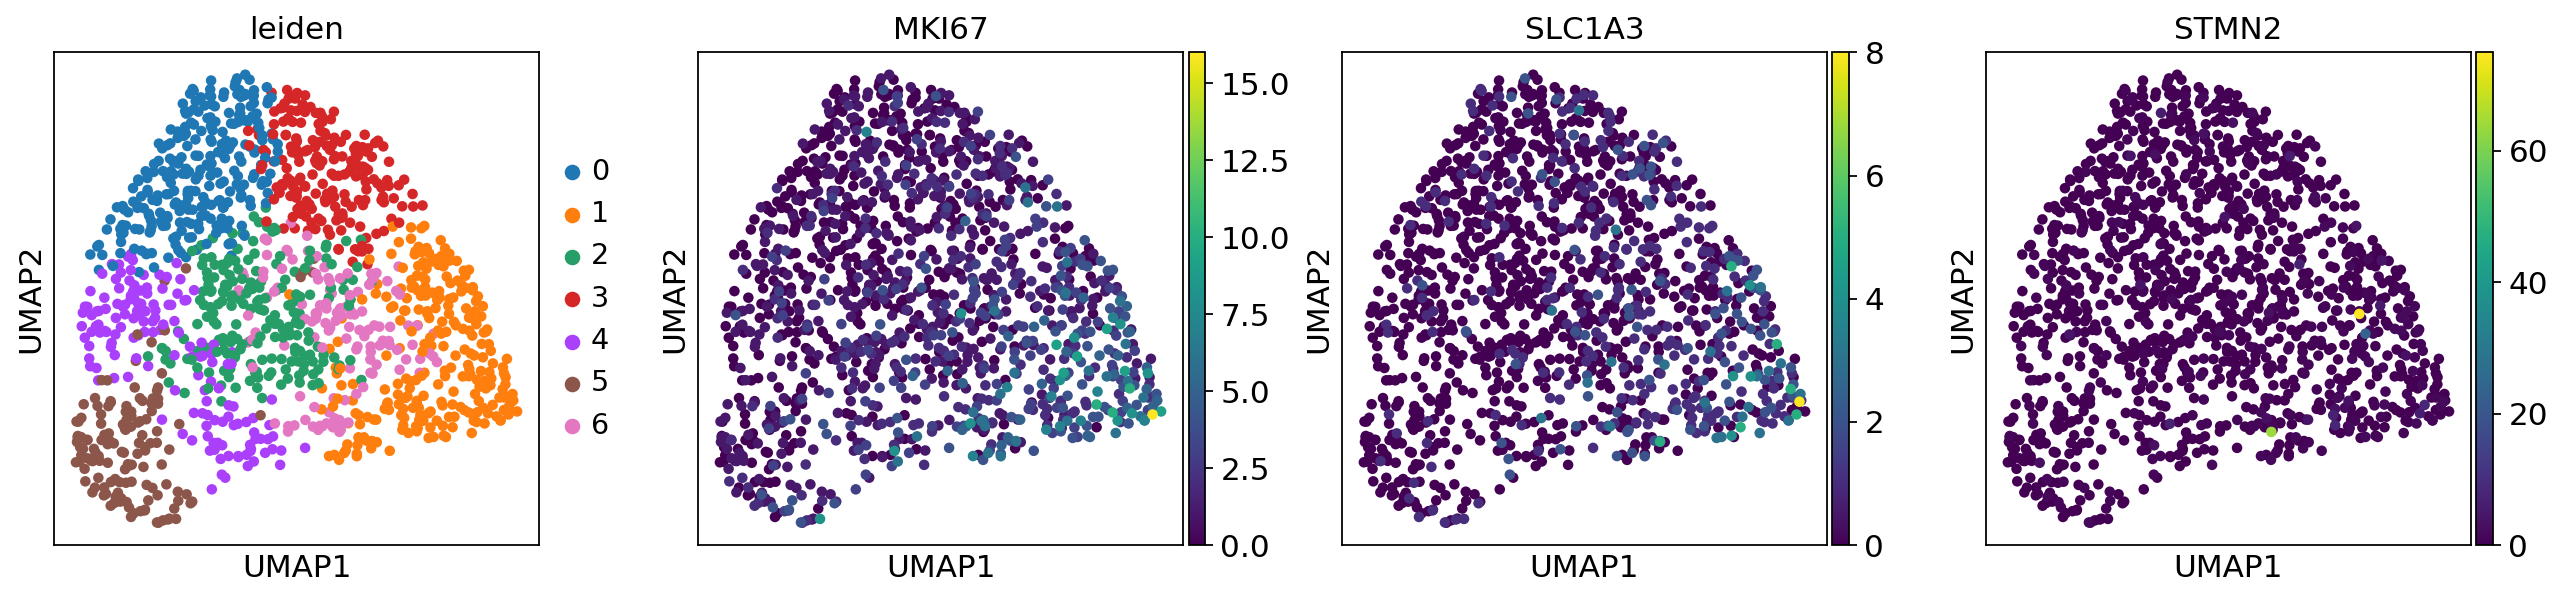

In [36]:
# Plot the clusters, which agree quite well with the result of Seurat.
sc.pl.umap(adata, color=['leiden', 'MKI67','SLC1A3','STMN2'])

In [37]:
# saving results
adata.write(results_file)

# Finding Gene Markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


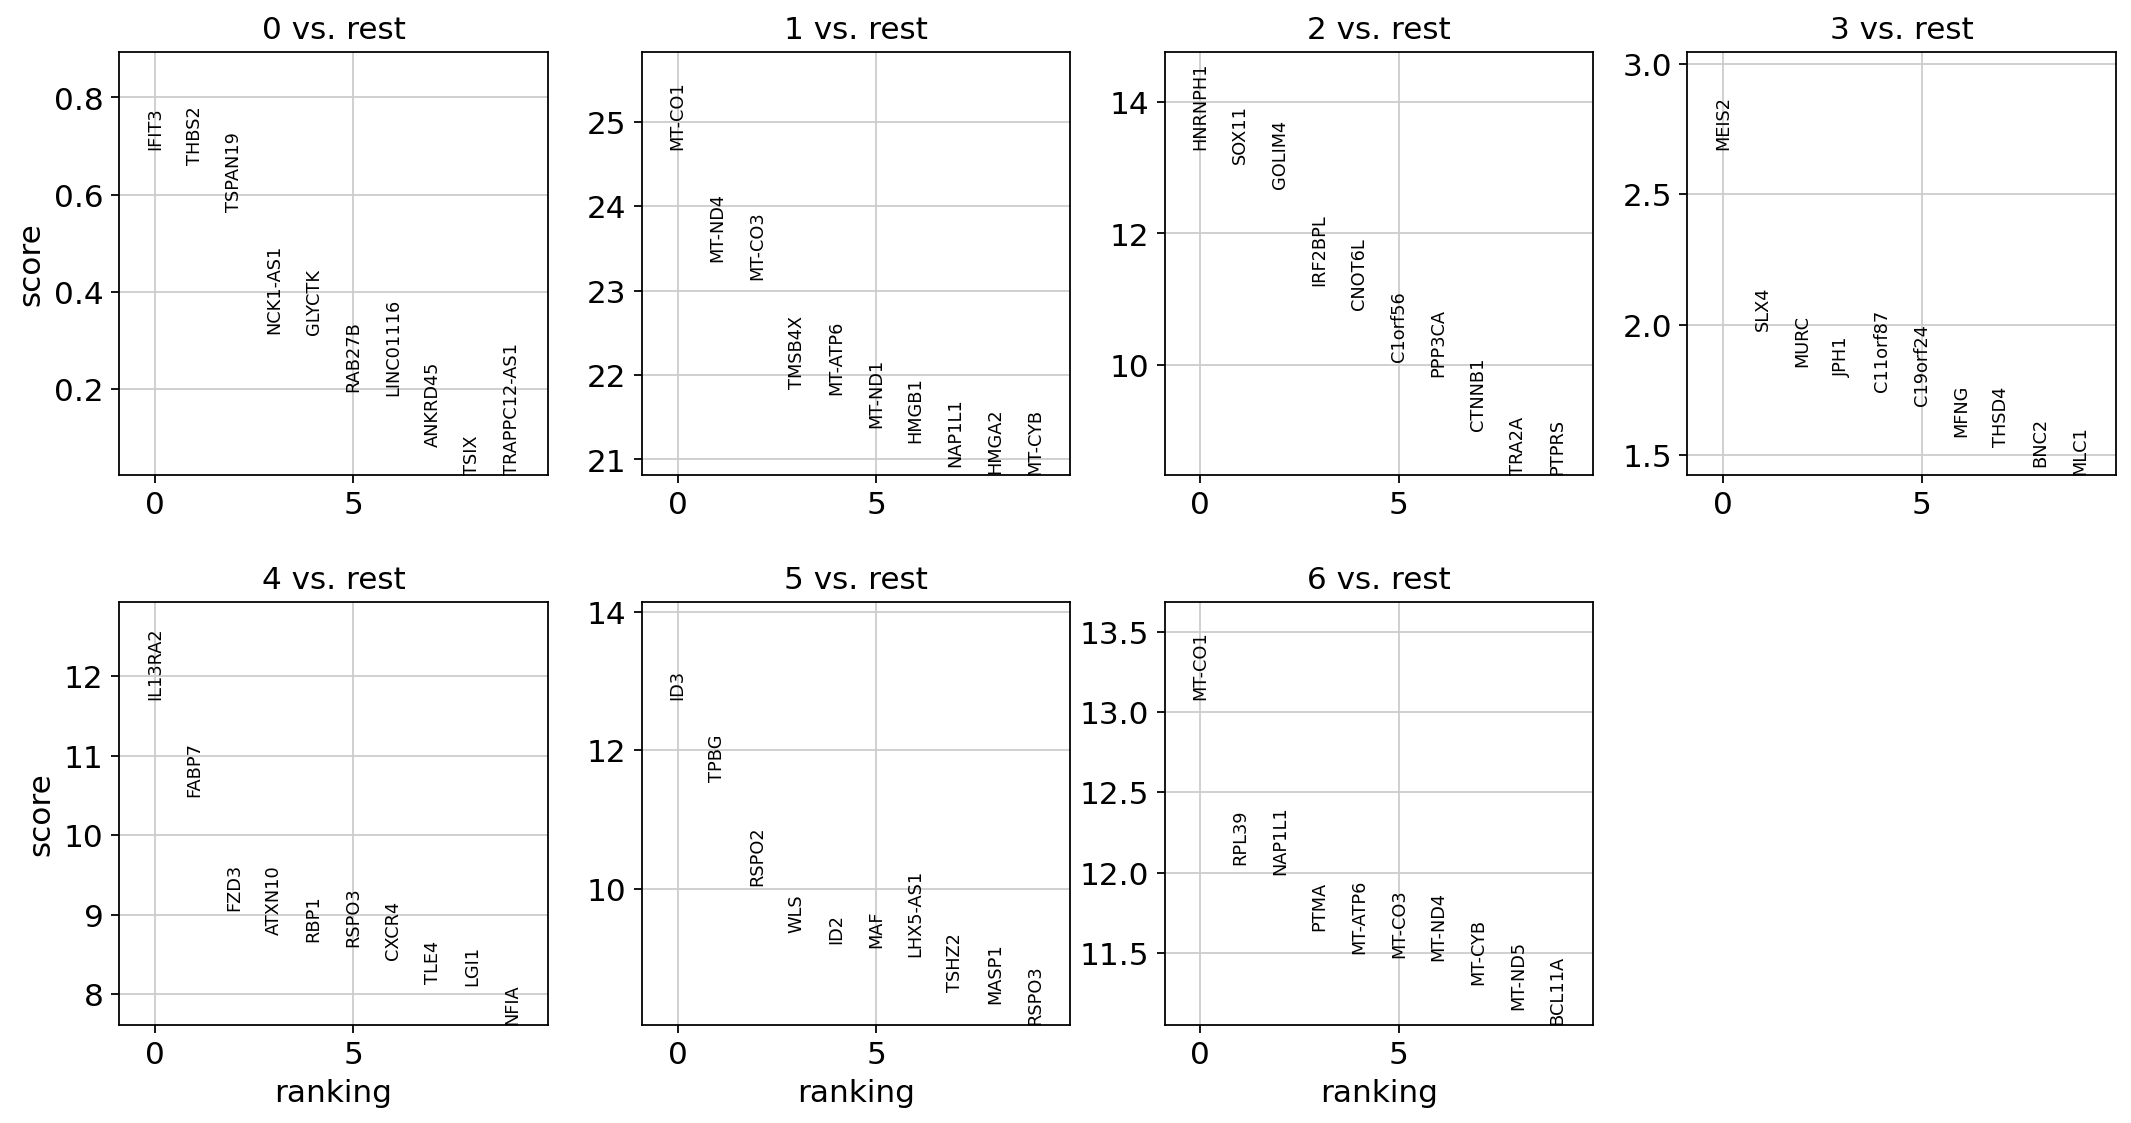

In [38]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [39]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n       0_p      1_n           1_p      2_n           2_p  \
0         IFIT3  0.488628   MT-CO1  5.369786e-78  HNRNPH1  2.192957e-31   
1         THBS2  0.507932   MT-ND4  1.507775e-72    SOX11  5.550436e-31   
2       TSPAN19  0.572128   MT-CO3  5.388226e-70   GOLIM4  6.946942e-29   
3      NCK1-AS1  0.753385   TMSB4X  1.299052e-63  IRF2BPL  1.499994e-23   
4        GLYCTK  0.754388  MT-ATP6  4.636227e-66   CNOT6L  7.116539e-23   
5        RAB27B  0.845467   MT-ND1  2.756715e-61  C1orf56  5.775879e-20   
6     LINC01116  0.851412    HMGB1  1.116660e-62   PPP3CA  1.147687e-19   
7       ANKRD45  0.934091   NAP1L1  1.576989e-60   CTNNB1  7.642833e-17   
8          TSIX  0.980004    HMGA2  1.482917e-59    TRA2A  3.072804e-15   
9  TRAPPC12-AS1  0.981145   MT-CYB  2.580158e-61    PTPRS  2.555420e-15   

        3_n       3_p      4_n           4_p       5_n           5_p      6_n  \
0     MEIS2  0.007829  IL13RA2  2.383855e-23       ID3  3.593129e-25   MT-CO1   
1      SLX4  0.049158    FABP7  3.598545e-20      TPBG  5.232037e-22    RPL39   
2      MURC  0.067084     FZD3  3.808722e-16     RSPO2  3.927092e-18   NAP1L1   
3      JPH1  0.072869   ATXN10  2.055414e-15       WLS  1.859040e-16     PTMA   
4  C11orf87  0.082396     RBP1  3.488680e-15       ID2  4.813989e-16  MT-ATP6   
5  C19orf24  0.092695    RSPO3  4.050958e-15       MAF  6.241771e-16   MT-CO3   
6      MFNG  0.117736    CXCR4  1.746704e-14  LHX5-AS1  1.417462e-15   MT-ND4   
7     THSD4  0.126613     TLE4  7.084000e-14     TSHZ2  2.515519e-14   MT-CYB   
8      BNC2  0.147301     LGI1  1.158470e-13     MASP1  5.447478e-14   MT-ND5   
9      MLC1  0.155979     NFIA  1.574233e-12     RSPO3  3.104572e-13   BCL11A   

            6_p  
0  1.319729e-27  
1  2.609590e-24  
2  6.097347e-24  
3  5.979992e-23  
4  9.696837e-23  
5  1.138250e-22  
6  1.072188e-22  
7  2.807578e-22  
8  1.091950e-21  
9  4.123831e-21

In [40]:
adata.write(results_file)

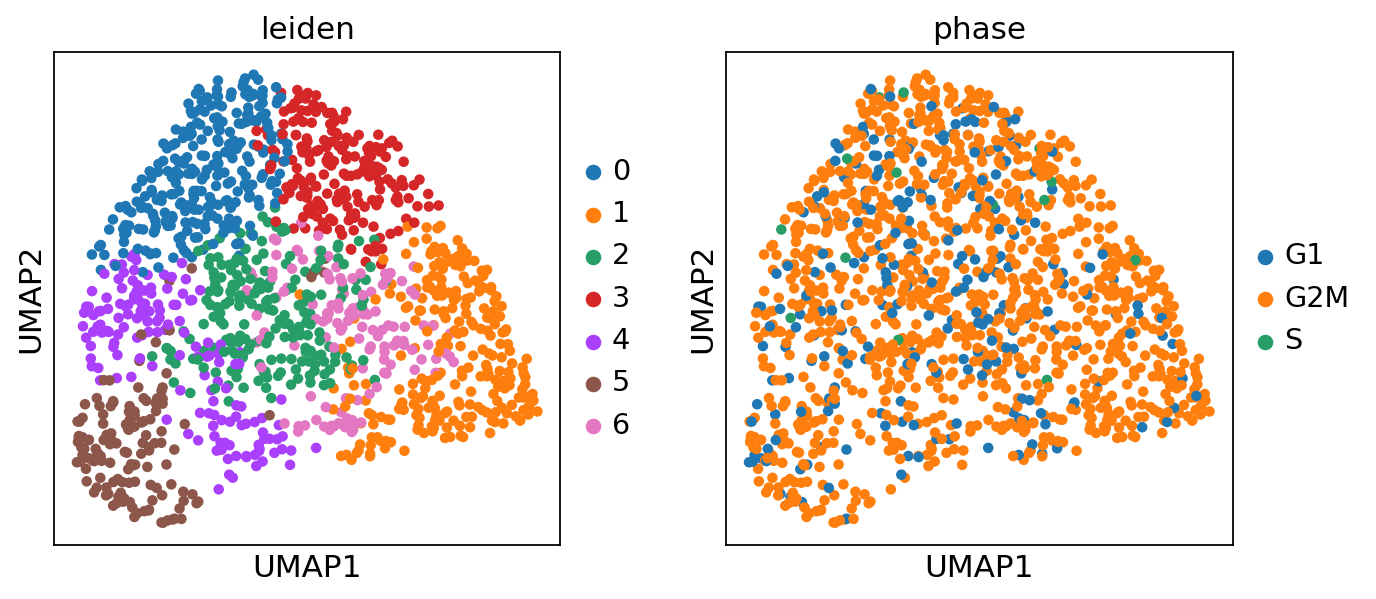

In [41]:
sc.pl.umap(adata,color=["leiden","phase"])

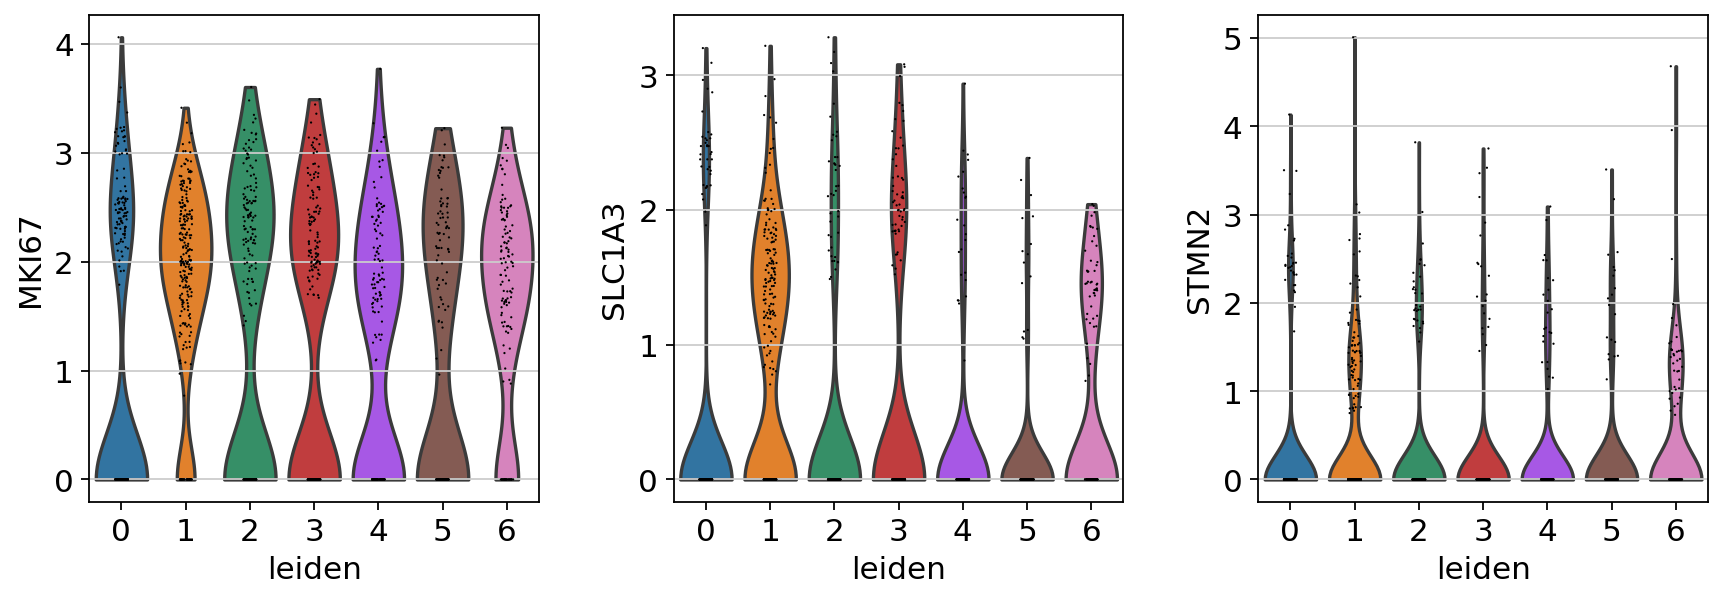

In [42]:
sc.pl.violin(adata, ['MKI67', 'SLC1A3','STMN2'], groupby='leiden',use_raw=False)

In [43]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0        1        2         3        4         5        6
0         IFIT3   MT-CO1  HNRNPH1     MEIS2  IL13RA2       ID3   MT-CO1
1         THBS2   MT-ND4    SOX11      SLX4    FABP7      TPBG    RPL39
2       TSPAN19   MT-CO3   GOLIM4      MURC     FZD3     RSPO2   NAP1L1
3      NCK1-AS1   TMSB4X  IRF2BPL      JPH1   ATXN10       WLS     PTMA
4        GLYCTK  MT-ATP6   CNOT6L  C11orf87     RBP1       ID2  MT-ATP6
5        RAB27B   MT-ND1  C1orf56  C19orf24    RSPO3       MAF   MT-CO3
6     LINC01116    HMGB1   PPP3CA      MFNG    CXCR4  LHX5-AS1   MT-ND4
7       ANKRD45   NAP1L1   CTNNB1     THSD4     TLE4     TSHZ2   MT-CYB
8          TSIX    HMGA2    TRA2A      BNC2     LGI1     MASP1   MT-ND5
9  TRAPPC12-AS1   MT-CYB    PTPRS      MLC1     NFIA     RSPO3   BCL11A

In [44]:
marker_genes = ['leiden','HBA2', 'HBG1','SMN1','ZNF211','TCF4','FZD3','PTMA','RPL39','TPBG','ID3']

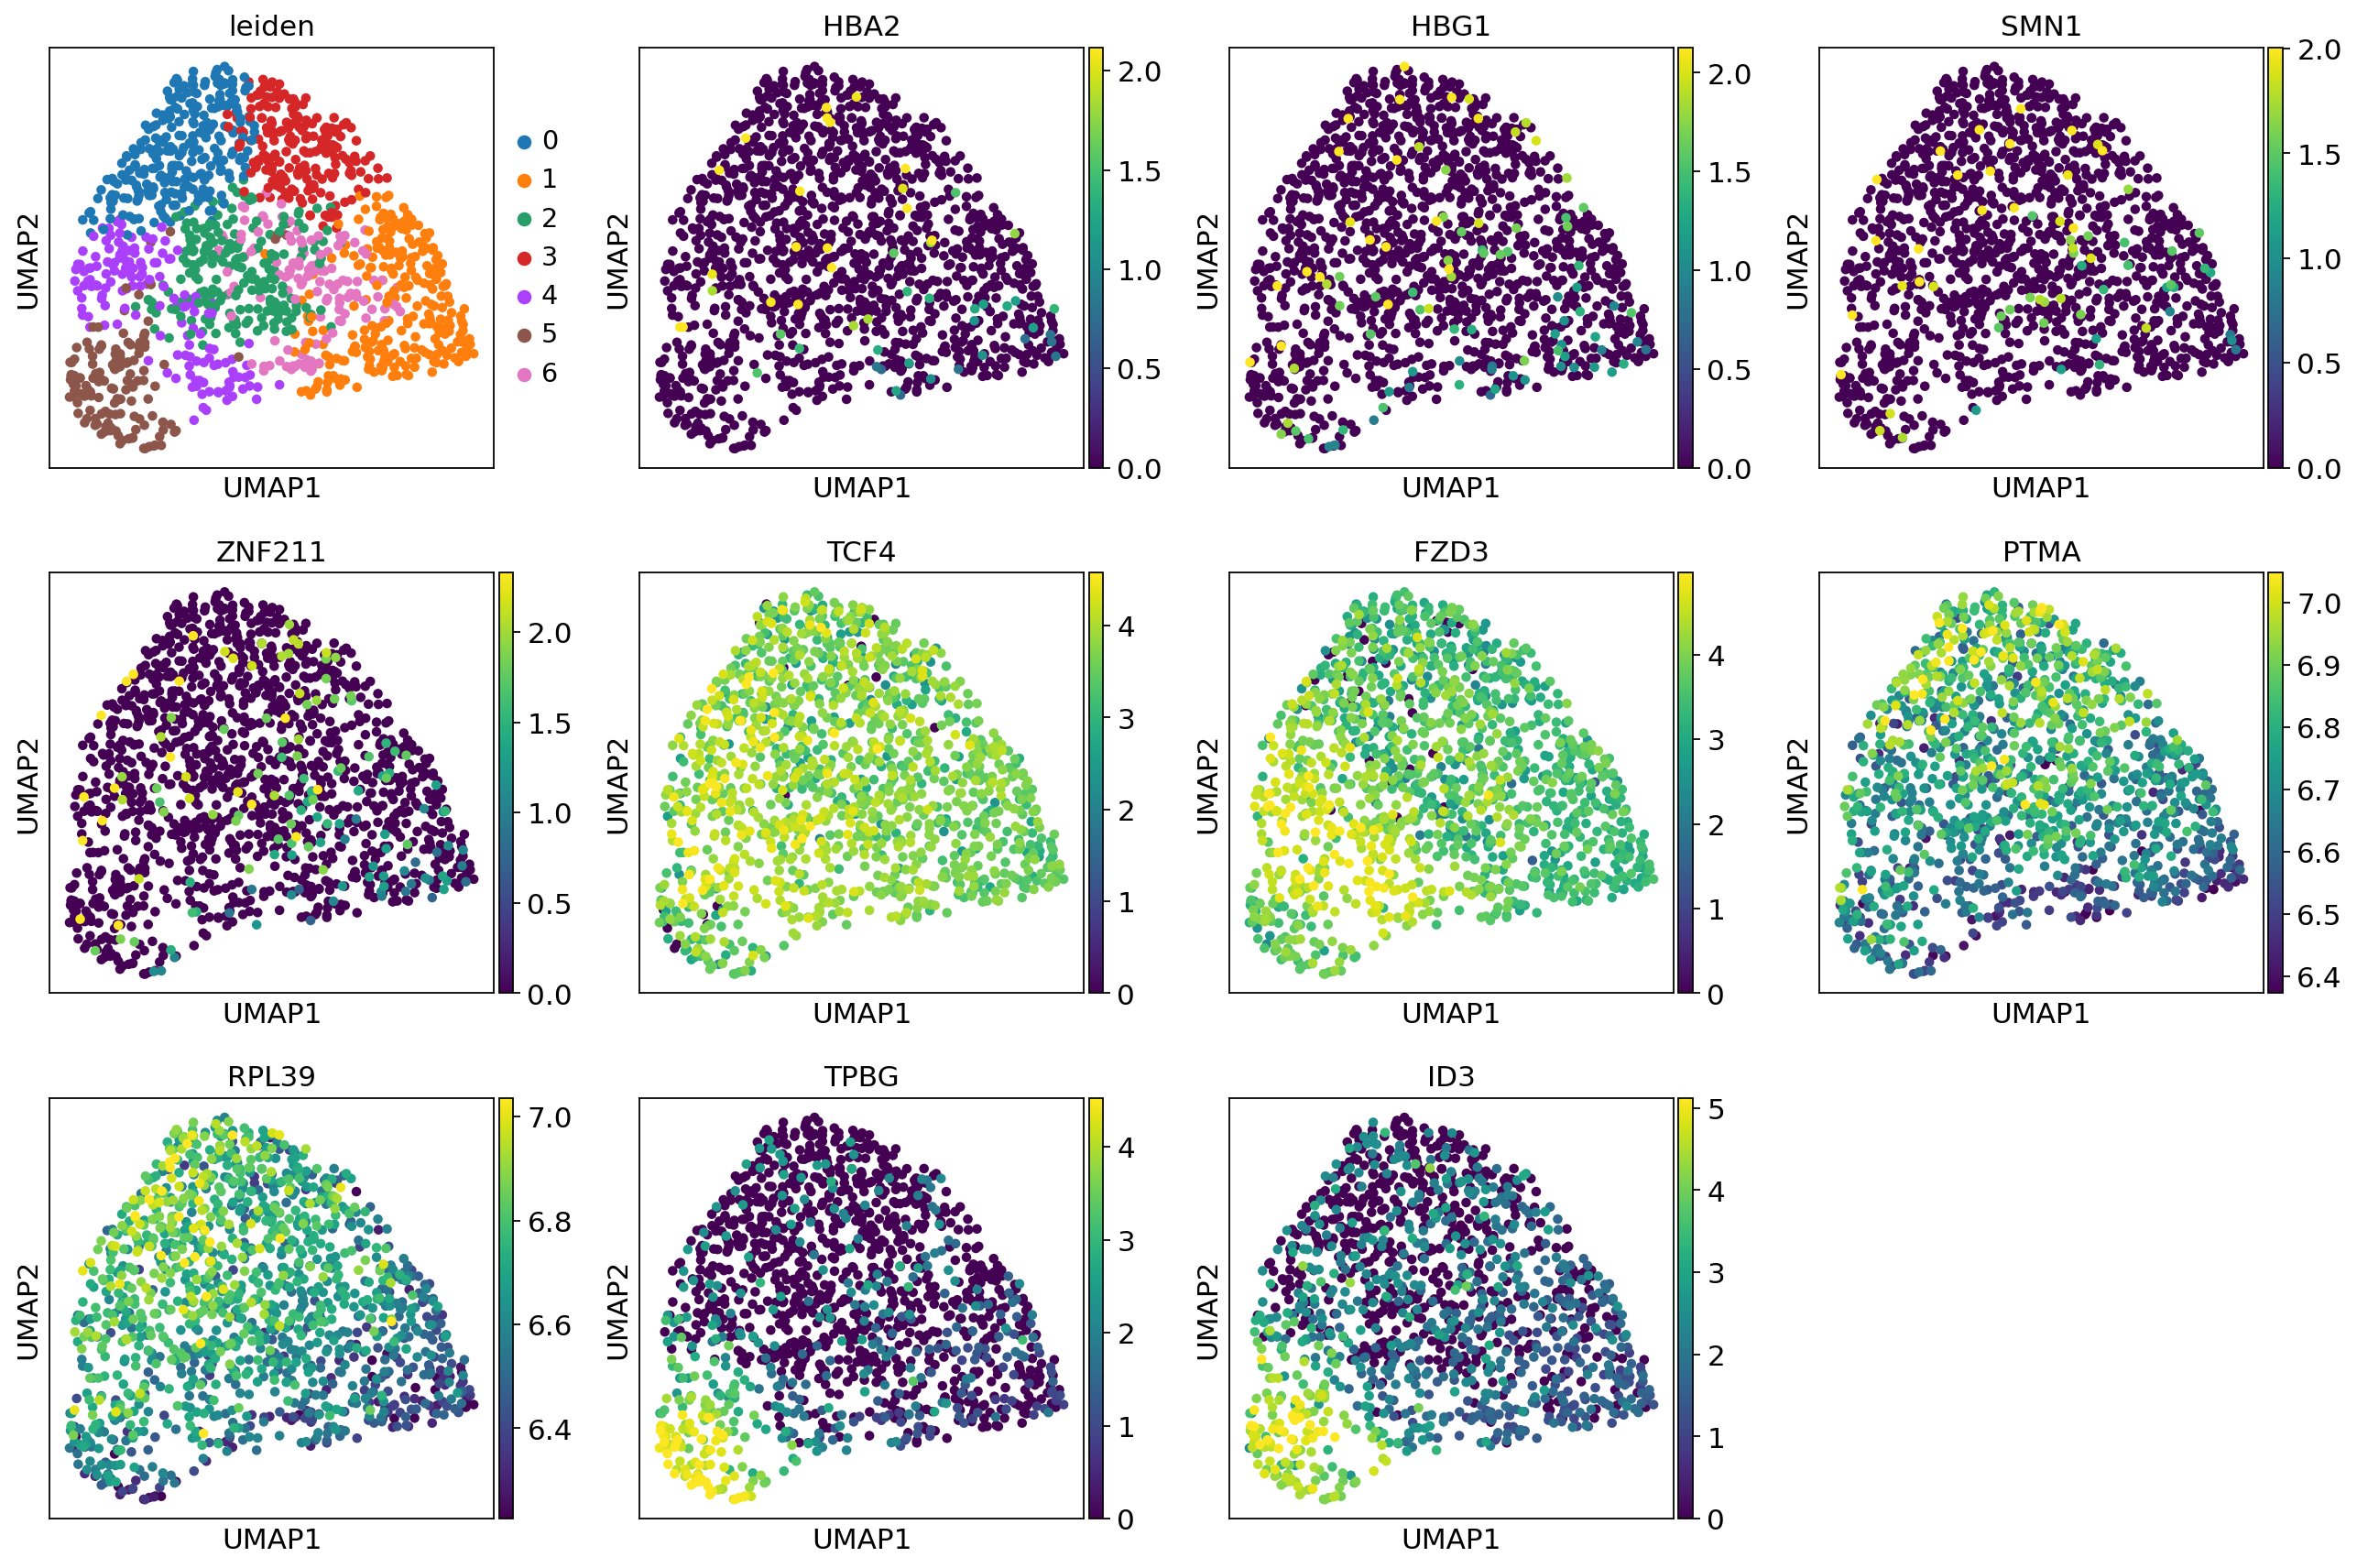

In [45]:
sc.pl.umap(adata,color=marker_genes,vmin="p1",vmax="p99",use_raw=False)

In [46]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9764079  0.97139555 0.9435245  0.93401325 0.92547303
     0.9073597  0.8934387  0.8864116  0.88346964 0.8746217  0.86424416
     0.8570546  0.8502049  0.84449077]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


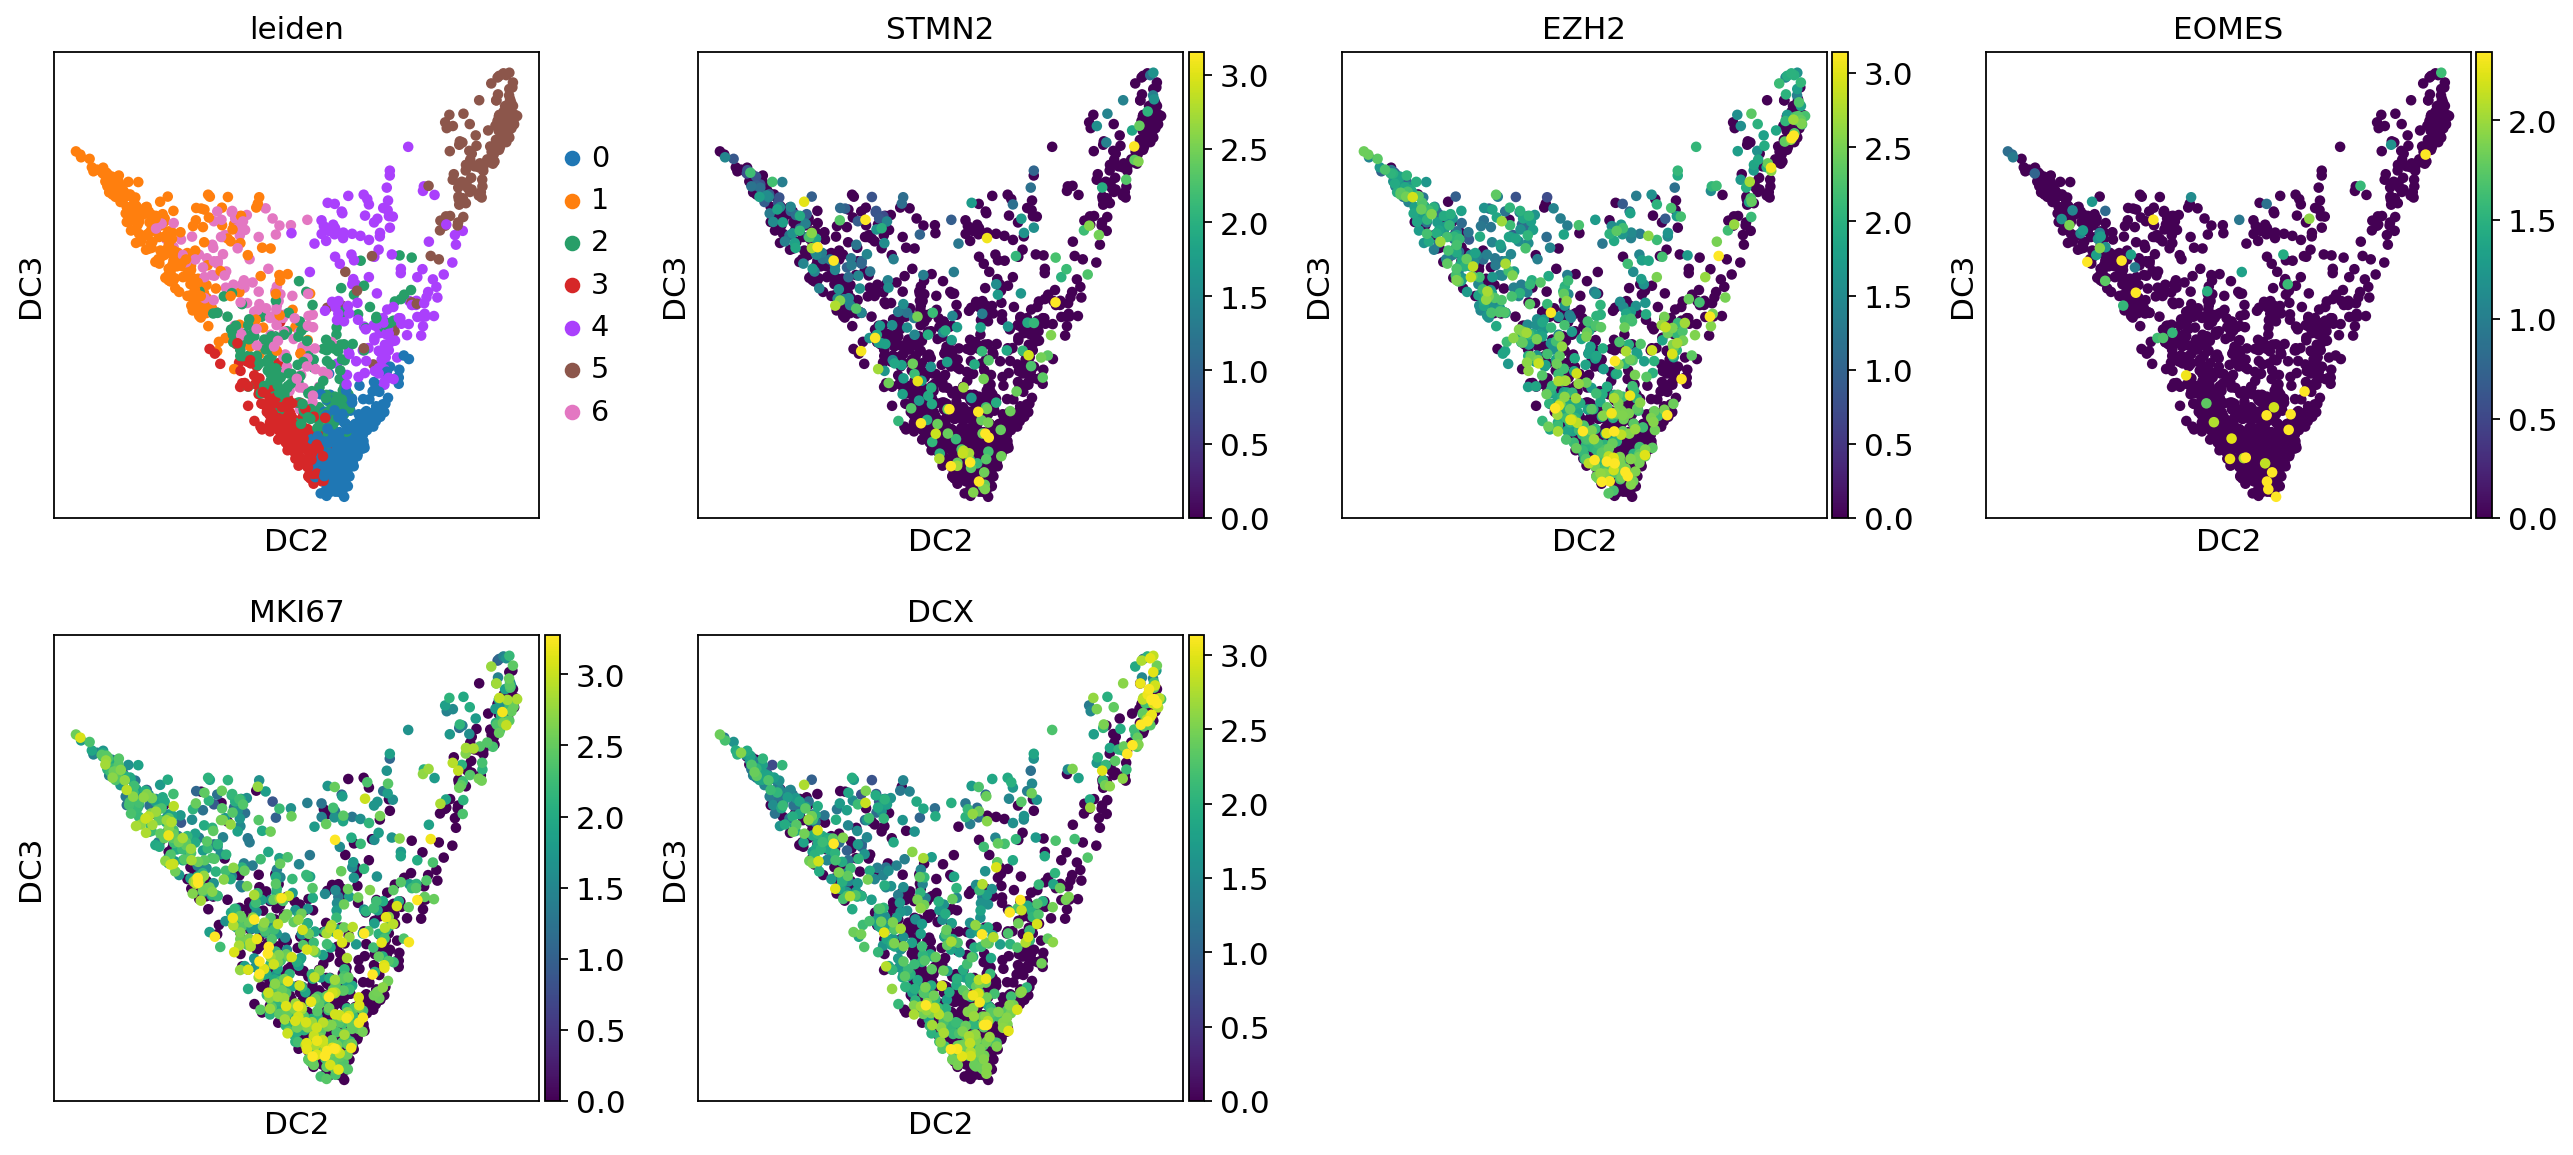

In [47]:
sc.pl.diffmap(adata,color=["leiden", 'STMN2','EZH2', 'EOMES','MKI67',"DCX"],dimensions=(1,2),vmin='p1',vmax='p99',use_raw=False)

In [48]:
sc.tl.leiden(adata,resolution=0.5,key_added="leiden")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: pericyte, endothelial, ExcDeepLayer, etc.


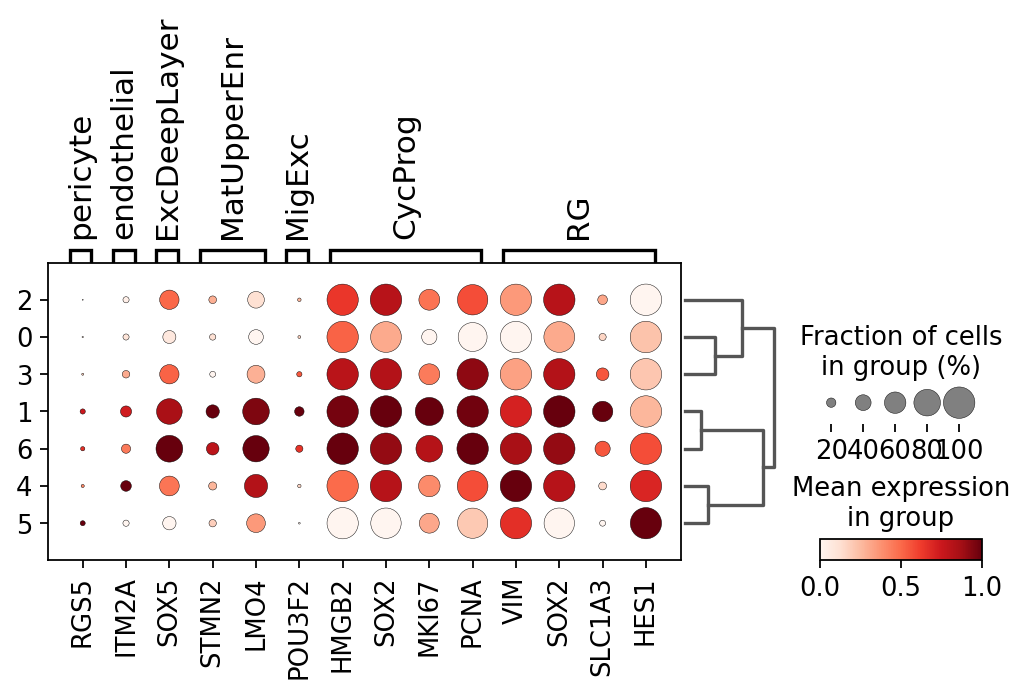

In [49]:
geschwind_ext = {
  'pericyte' : ['RGS5'],
  'endothelial' : ['ITM2A'],
  'ExcDeepLayer' : ['SOX5'],
  'MatUpperEnr' : ['STMN2','LMO4'],
  'MigExc' : ['POU3F2'],
  'CycProg' : ['HMGB2','SOX2','MKI67','PCNA'],
  'RG' : ['VIM','SOX2','SLC1A3','HES1']
}

sc.pl.dotplot(adata,geschwind_ext , 'leiden', dendrogram=True,save="combo_markersDotplot",use_raw=False,log=True,standard_scale='var')

In [50]:
### DONE BUT NOT REV.
cluster2annotation = {
    "0": "RG", "1": "Neu","2":"RG", "3": "RG",
    "4": "RG", "5" : "RG", "6" : "Neu"
}
 
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [51]:
### DONE BUT NOT REV.

cluster2annotation = {
    "0": "vRG", "1": "MigExc","2":"vRG", "3": "vRG",
    "4": "vRG", "5" : "vRG",  "6" : "MigExc"
}
 
adata.obs['celltype2'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [52]:
### DONE BUT NOT REV.
new_cluster_names = [
    '0/vRG', '1/MigExc',
    '2/vRG', '3/vRG',
    '4/vRG', '5/vRG', '6/MigExc']
adata.rename_categories('leiden', new_cluster_names)

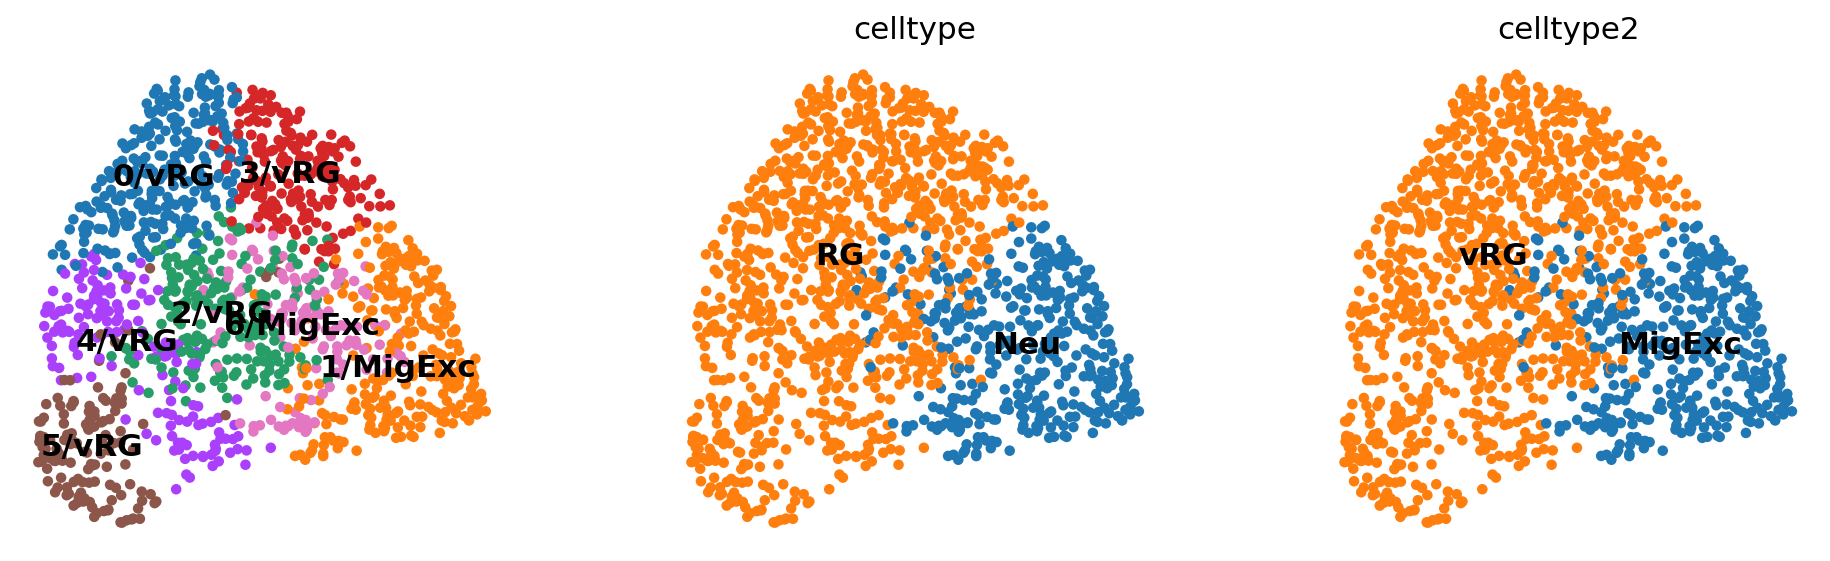

In [53]:
sc.pl.umap(adata, color=['leiden','celltype','celltype2'], legend_loc='on data', title='', frameon=False, save='.pdf')

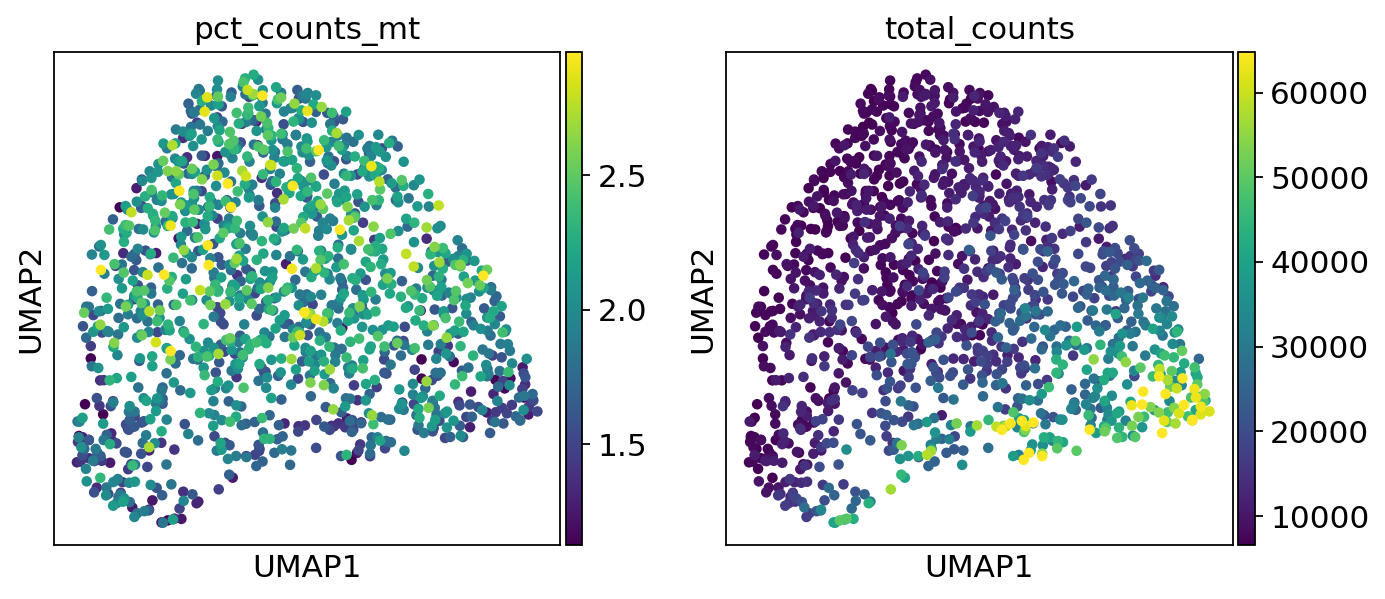

In [54]:
sc.pl.umap(adata,color=['pct_counts_mt','total_counts'],vmin='p1',vmax='p99')

In [55]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9764079  0.97139555 0.9435245  0.93401325 0.92547303
     0.9073597  0.8934387  0.8864116  0.88346964 0.8746217  0.86424416
     0.8570546  0.8502049  0.84449077]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [56]:
adata.obs.leiden.value_counts()

0/vRG       265
1/MigExc    252
2/vRG       202
3/vRG       195
4/vRG       152
5/vRG       138
6/MigExc    129
Name: leiden, dtype: int64

In [57]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9764079  0.97139555 0.9435245  0.93401325 0.92547303
     0.9073597  0.8934387  0.8864116  0.88346964 0.8746217  0.86424416
     0.8570546  0.8502049  0.84449077]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


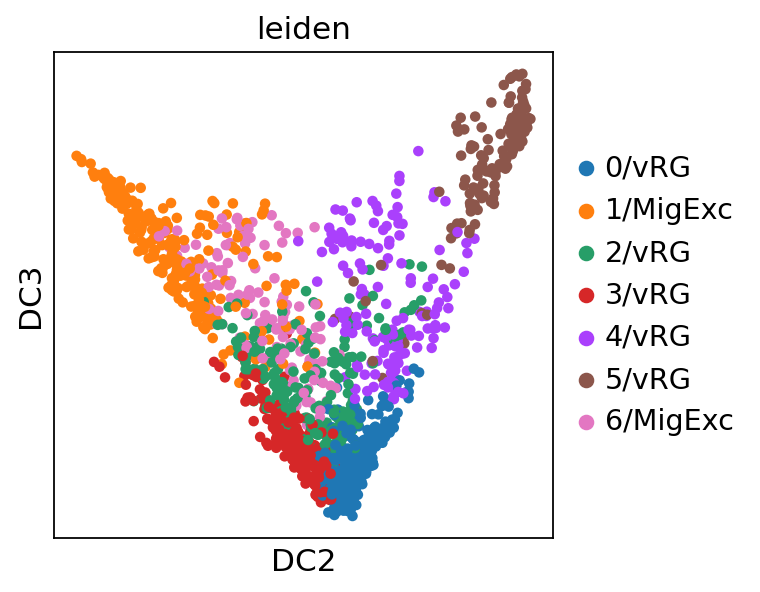

In [58]:
# no adata_check bcs no endo, pery... 
sc.pl.diffmap(adata,color="leiden",dimensions=(1,2))

In [59]:
adata.obs.leiden

AAACGGGCAGGTCGTC-1       5/vRG
AAACGGGGTTCCACGG-1       5/vRG
AAAGATGAGATCTGCT-1       3/vRG
AAAGATGCATTCTCAT-1       2/vRG
AAAGATGGTACATGTC-1       2/vRG
                        ...   
TTTGCGCAGCAGATCG-1       0/vRG
TTTGGTTAGTTACCCA-1    1/MigExc
TTTGGTTCATTATCTC-1    1/MigExc
TTTGGTTTCCTAAGTG-1    6/MigExc
TTTGTCAGTGAGTGAC-1       5/vRG
Name: leiden, Length: 1333, dtype: category
Categories (7, object): ['0/vRG', '1/MigExc', '2/vRG', '3/vRG', '4/vRG', '5/vRG', '6/MigExc']

In [61]:
adata.write_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS19_01_20240208_v1.h5ad")

In [3]:
adata=sc.read_h5ad("/group/testa/Project/CBOProgPools/h5ad/CS19_01_20240208_v1.h5ad")

In [4]:
adata.obs['stage'] = 'CS19'

In [5]:
adata.write_h5ad('/group/testa/Project/CBOProgPools/h5ad/CS19_01_20240208_v1.h5ad')